In [ ]:
from desmog_scrapper import create_quote_dataframe, load_desmog_from_csv, add_data_quality_columns, remove_blockquotes
from typing import List
from bs4 import BeautifulSoup
import requests
from pydantic import BaseModel

In [ ]:
desmog_data = load_desmog_from_csv("desmog_dataset.csv")

df = create_quote_dataframe(desmog_data)
df = df.drop_duplicates(subset='quote')
add_data_quality_columns(df)
print(df.quote.size)

13988


In [34]:
df = create_quote_dataframe(desmog_data)
df = remove_blockquotes(df)
add_data_quality_columns(df)
print(df.quote.size)
df = df.drop_duplicates(subset='quote')
print(df.quote.size)

7397
7214


In [35]:
df.to_csv("df_blockquote_cleaned.csv",index=False)

In [23]:
df.is_full.value_counts()

is_full
True     4365
False    2849
Name: count, dtype: int64

In [21]:
df.sample(10)

,name,countries,url,item_type,quote,section_source,word_count,is_full
2209,Centre for Policy Studies,United Kingdom,https://www.desmog.com/centre-policy-studies/,organization,Any serious effort will be beset by vested int...,stance_quote,23,False
6821,Institute for Liberty,United States,https://www.desmog.com/institute-liberty/,organization,What’s the man-made portion of the climate cha...,stance_quote,54,True
3058,Ken Cuccinelli,United States,https://www.desmog.com/ken-cuccinelli/,individual,"My point of disagreement is that, that was an ...",key_quote,36,True
1563,William Briggs,United States,https://www.desmog.com/william-briggs/,individual,senior contributor,stance_quote,2,False
11472,Rick Perry,United States,https://www.desmog.com/rick-perry/,individual,My past statements made over five years ago ab...,key_quote,20,True
2370,Ross Clark,United Kingdom,https://www.desmog.com/ross-clark/,individual,If Rishi Sunak caves in to the wind turbine ze...,key_quote,23,False
8623,Angela Logomasini,United States,https://www.desmog.com/angela-logomasini/,individual,Carson’s writings included many inflammatory a...,key_quote,60,True
9283,Jennifer Marohasy,Australia,https://www.desmog.com/jennifer-marohasy/,individual,Global warming is actually not a hard issue to...,key_quote,74,True
13378,Lamar Smith,United States,https://www.desmog.com/lamar-smith/,individual,climate alarmists,key_quote,2,False
2376,Ross Clark,United Kingdom,https://www.desmog.com/ross-clark/,individual,the current moratorium on fracking […] is utte...,key_quote,9,False


In [32]:
best_quotes = df[df['is_full']]
best_quotes = best_quotes[best_quotes["word_count"]>10]
print(best_quotes.quote.size)

for quote in best_quotes.sample(10).quote:
    print(quote)
    print('***')

3838
Calculations behind the social cost of carbon need to reflect empirical evidence about low climate sensitivity, and when this is done, the numbers appear to be much lower than those currently in use.
***
Let’s face it, environmentalism became the religion of the twenty-first century!
***
We need to keep in mind that this is about reducing emissions and not reducing production,
***
I was pleased to hear a BBC programme on Sunday pointing out that adaptation to climate change was a sensible response in addition to or rather than trying to cut carbon emissions.
***
While the general opinion supports the hypothesis about harmful global warming resulting from burning of fossil fuels, hard data do not support beyond all doubt the assertion that global warming is indeed happening and what is more, the theory does not prove that burning fossil fuels causes harm to the nature…[T]he theory of global warming is built on shaky foundations. It is, at least, questionable to set ourselves costly

In [33]:
best_quotes.to_csv("best_quotes.csv",index=False)

### Insights
- If you are interested in a variety of quotes, try to get the blockquotes removed with "remove_blockquotes".
In articles which contain a "Stance on Climate Change" or "key quote" section with quotes, there are way higher chances from my exploration that the "block quotes" extracted will be non climate related.

- some quotes are still from the wrong sections. https://www.desmog.com/william-briggs/ => stance on gay marriage is h3 under the h2 of climate change and quotes are still inside it and considered "stance_quote" which is wrong.



## Data viz

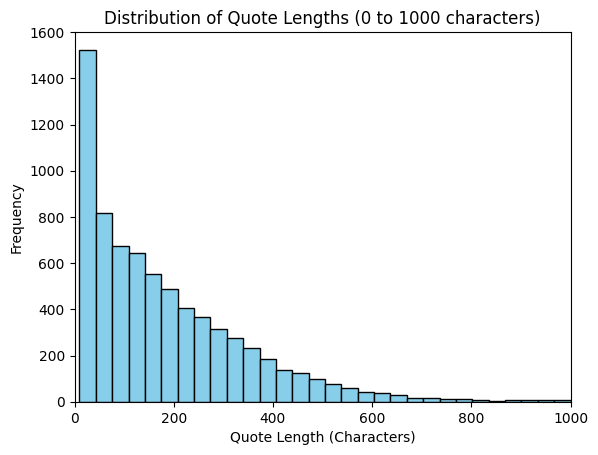

In [24]:
import matplotlib.pyplot as plt

# Calculate quote lengths
df["quote_length"] = df["quote"].apply(len)

# Filter quotes with length between 0 and 1000 characters
filtered_df = df[(df["quote_length"] >= 0) & (df["quote_length"] <= 1000)]

# Plot histogram of quote lengths (limited to 0-1000 characters)
plt.hist(filtered_df["quote_length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Quote Lengths (0 to 1000 characters)")
plt.xlabel("Quote Length (Characters)")
plt.ylabel("Frequency")
plt.xlim(0, 1000)  # Limiting the x-axis to 0-1000 characters
plt.show()


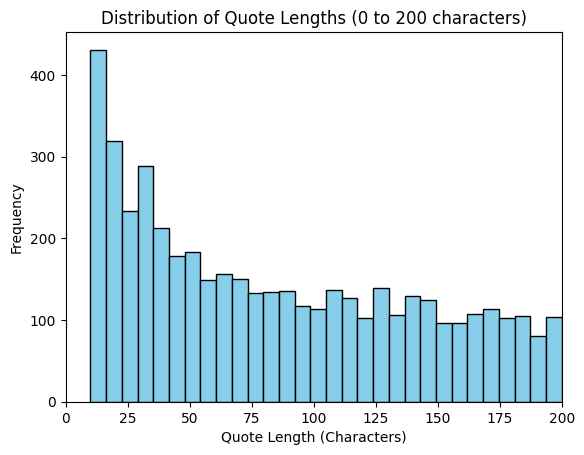

In [25]:
import matplotlib.pyplot as plt

# Calculate quote lengths
df["quote_length"] = df["quote"].apply(len)

# Filter quotes with length between 0 and 1000 characters
filtered_df = df[(df["quote_length"] >= 0) & (df["quote_length"] <= 200)]

# Plot histogram of quote lengths (limited to 0-200 characters)
plt.hist(filtered_df["quote_length"], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Quote Lengths (0 to 200 characters)")
plt.xlabel("Quote Length (Characters)")
plt.ylabel("Frequency")
plt.xlim(0, 200)  # Limiting the x-axis to 0-200 characters
plt.show()


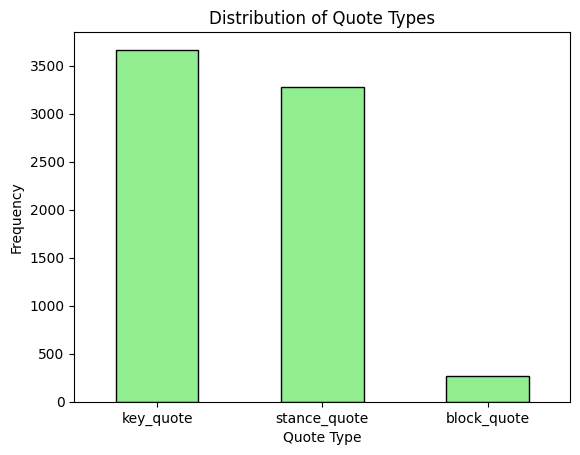

In [26]:
# Plot the distribution of quote types
quote_type_counts = df["section_source"].value_counts()

quote_type_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Distribution of Quote Types")
plt.xlabel("Quote Type")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


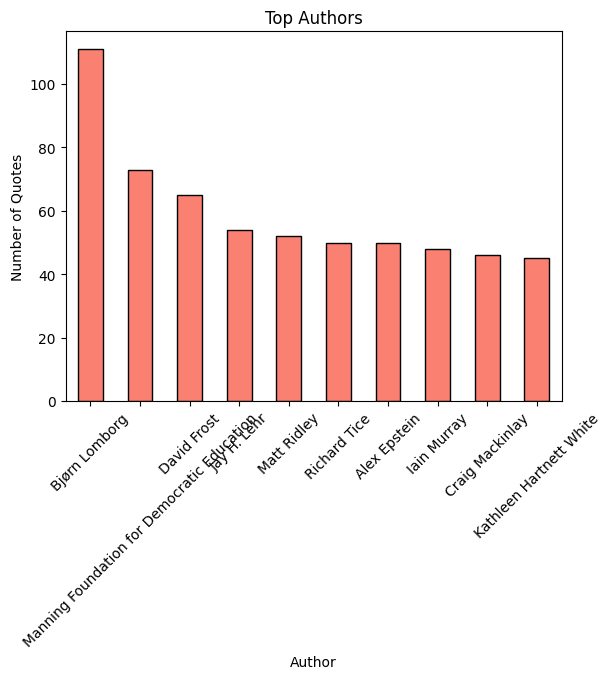

In [27]:
# Count the most frequent names
top_authors = df["name"].value_counts().head(10)

top_authors.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Top Authors")
plt.xlabel("Author")
plt.ylabel("Number of Quotes")
plt.xticks(rotation=45)
plt.show()


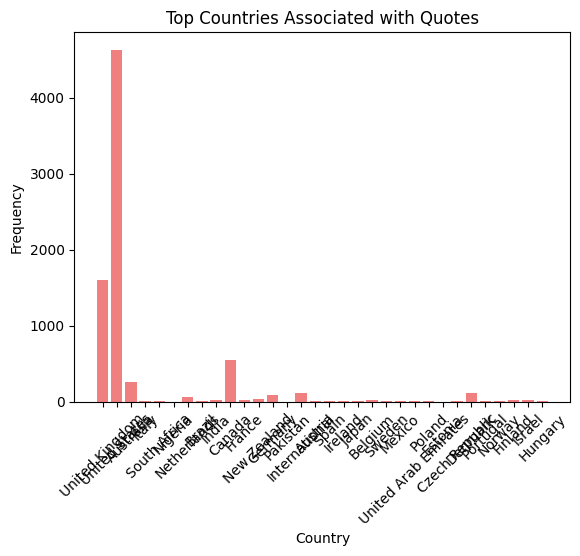

In [28]:
from collections import Counter

# Flatten the list of countries into a single list
all_countries = [country.strip() for countries in df["countries"] for country in countries.split(',')]

# Count the most common countries
country_counts = Counter(all_countries)

# Plot the most common countries
plt.bar(country_counts.keys(), country_counts.values(), color='lightcoral')
plt.title("Top Countries Associated with Quotes")
plt.xlabel("Country")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()
